In [28]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm
from annoy import AnnoyIndex

import torch
from PIL import Image
import open_clip
import torch
from PIL import Image
import open_clip

# Function to build an index of images
def get_file_list(root_dir, extensions=['.jpg', '.jpeg', '.png']):
    """Get a list of image paths from a directory."""
    file_list = []
    for root, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

## YOLO World

In [1]:
from ultralytics import YOLOWorld
from ultralytics.data.augment import LetterBox
import numpy as np
import cv2

from torch import nn
model_yolo = YOLOWorld("yolov8s-world.pt")  # or select yolov8m/l-world.pt for different sizes
m = nn.Sequential(*model.model.model[:10])

def preprocess(im):
    """
    Prepares input image before inference.

    Args:
        im (torch.Tensor | List(np.ndarray)): BCHW for tensor, [(HWC) x B] for list.
    """
    not_tensor = not isinstance(im, torch.Tensor)
    if not_tensor:
        im = np.stack(pre_transform(im))
        im = im[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
        im = np.ascontiguousarray(im)  # contiguous
        im = torch.from_numpy(im)

    im = im.to("cpu")
    im = im.to(torch.float32)
    if not_tensor:
        im /= 255  # 0 - 255 to 0.0 - 1.0
    flattened_features = im.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

def pre_transform(im):
    """
    Pre-transform input image before inference.

    Args:
        im (List(np.ndarray)): (N, 3, h, w) for tensor, [(h, w, 3) x N] for list.

    Returns:
        (list): A list of transformed images.
    """
    same_shapes = len({x.shape for x in im}) == 1
    letterbox = LetterBox(new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32)
    return [letterbox(image=x) for x in im]

def extract_features_yoloworld(image_path):
    # Load the image
    img = cv2.imread(image_path)
    features = preprocess([img])
    return features

100%|██████████| 25.9M/25.9M [00:37<00:00, 734kB/s] 


NameError: name 'model' is not defined

In [53]:
new_feature = extract_features_yoloworld('/home/tung/Downloads/images (2).png')
new_feature2 = extract_features_yoloworld('/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/1/frame_0009.jpg')
new_feature @ new_feature2.T

tensor(0.8188)

In [45]:
import cv2
import torch
img1 = cv2.imread('/home/tung/Downloads/download.jpeg')
im_feat1= preprocess([img1])
print(im_feat1.size)

<built-in method size of Tensor object at 0x75900229fb00>


## VGG

In [ ]:
# Initialize ResNet50 model
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features_VGG(img_path, model):
    """Extract features from an image using ResNet50."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

## CLIP

In [ ]:
# Load CLIP model and tokenizer
model_clip, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model_clip.eval()
# Function to extract features from an image using CLIP model
def extract_features_clip(img_path, model, preprocess):
    """Extract features from an image using CLIP model."""
    image = preprocess(Image.open(img_path)).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    # Step 3: Flatten the features to a 1D array
    flattened_features = image_features.flatten()

    # Step 4: Normalize the features
    normalized_features = flattened_features / flattened_features.norm()

    return normalized_features

In [29]:
# Load images and extract features
root_dir = '/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/2'
filenames = get_file_list(root_dir)
feature_list_clip = [extract_features_clip(filename, model_clip, preprocess) for filename in tqdm(filenames)]

100%|██████████| 376/376 [00:39<00:00,  9.46it/s]


In [ ]:
# Load images and extract features
root_dir = '/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/2'
filenames = get_file_list(root_dir)
feature_list_vgg = [extract_features_VGG(filename, model_clip, preprocess) for filename in tqdm(filenames)]

tensor(0.3681)
Bức ảnh gần giống nhất: /media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/2/frame_0055.jpg


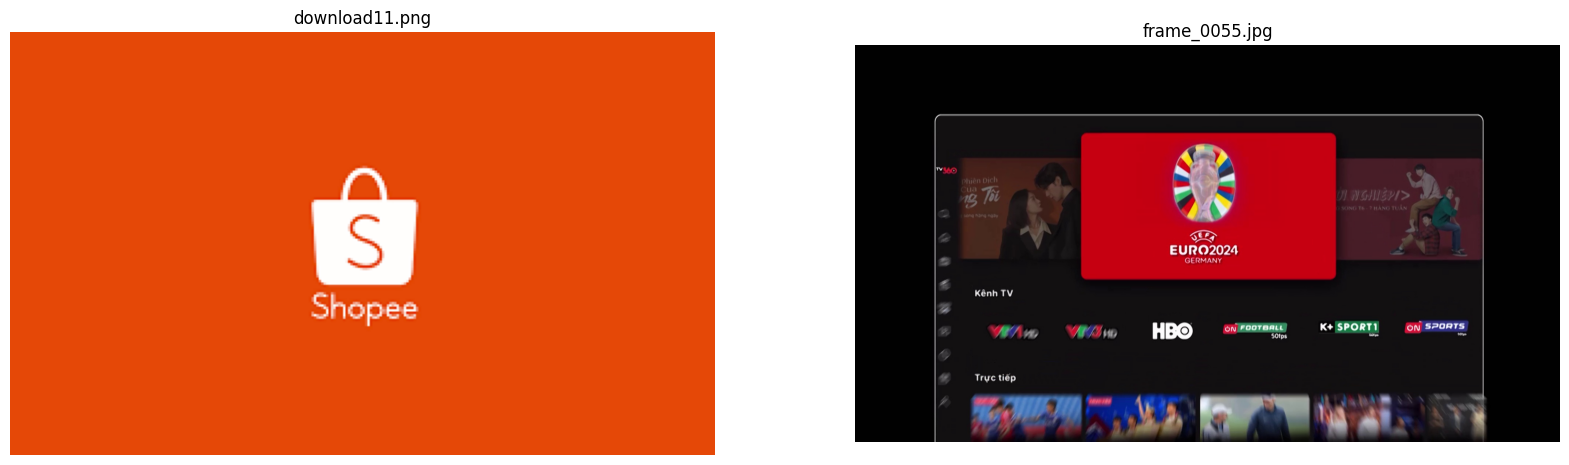

In [58]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from tqdm import tqdm
from annoy import AnnoyIndex

duplicate_threshold = 1

# Đường dẫn đến ảnh mới
new_image_path = "/home/tung/Downloads/download11.png"

# Trích xuất feature của ảnh mới
new_feature = extract_features_clip(new_image_path, model,preprocess)

# Sử dụng ANNOY để tìm những bức ảnh gần giống nhất
f = len(feature_list_clip[0])
t = AnnoyIndex(f, 'euclidean')
for i, feature in enumerate(feature_list_clip):
    t.add_item(i, feature)
t.build(1500)

# Tìm kiếm bức ảnh gần giống nhất với ảnh mới
nearest_ids = t.get_nns_by_vector(new_feature, 1)
nearest_image_index = nearest_ids[0]
nearest_image_feature = feature_list_clip[nearest_image_index]


# Kiểm tra xem ảnh mới có nằm trong tập hợp những bức ảnh đặc trưng nhất hay không
#is_duplicate = np.linalg.norm(np.array(new_feature) - np.array(nearest_image_feature)) < duplicate_threshold

print(new_feature @ nearest_image_feature.T)


# if is_duplicate:
#     print("Ảnh mới này giống với một trong những bức ảnh đặc trưng nhất.")
# else:
#     print("Ảnh mới này không giống với bất kỳ bức ảnh đặc trưng nào.")

# # Nếu bạn muốn in ra bức ảnh gần giống nhất
nearest_image_path = filenames[nearest_image_index]
print(f"Bức ảnh gần giống nhất: {nearest_image_path}")

# # Bạn có thể hiển thị bức ảnh gần giống nhất cùng với ảnh mới
def visualize_images(image_paths):
    """Visualize a list of images."""
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()

visualize_images([new_image_path, nearest_image_path])


In [57]:
new_feature = extract_features_clip("/home/tung/Downloads/download.jpeg", model, preprocess)
new_feature2 = extract_features_clip("/home/tung/Downloads/download11.png", model, preprocess)
new_feature @ new_feature2.T

tensor(0.7336)

## OCR

In [108]:
import easyocr
import re

def ocr_re_image(image_path):
    # Khởi tạo OCR reader
    reader = easyocr.Reader(['vi'])
    # Đọc text từ ảnh
    result = reader.readtext(image_path)
    # Trích xuất tất cả các phần text từ kết quả OCR
    texts = [item[1] for item in result]
    # Split những câu thành nhiều từ dựa trên khoảng trắng và chuyển tất cả ký tự về chữ thường
    words = []
    for text in texts:
        # Split thành các từ và chuyển về chữ thường
        split_words = re.split(r'\s+', text.lower())
        # Loại bỏ các ký tự đặc biệt, chỉ giữ lại chữ cái và số tiếng Việt
        clean_words = [re.sub(r'[^a-zA-Z0-9áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]', '', word) for word in split_words]
        words.extend(clean_words)
    # Loại bỏ từ trùng lặp
    unique_words = list(set(words))
    # Sắp xếp các từ theo thứ tự chữ cái đầu của từ theo alphabet
    unique_words.sort()
    result_string = ' '.join(unique_words
    return result_string

In [102]:
from difflib import SequenceMatcher

def calculate_similarity(str1, str2):
  """Calculates the similarity between two strings as a percentage."""

  matcher = SequenceMatcher(None, str1.lower(), str2.lower())  
  similarity_ratio = matcher.ratio()
  similarity_percent = similarity_ratio * 100

  return similarity_percent

# Example usage
string1 = " 0 35f9 360 4g bạn của dung giải giới miễn phi riêng telecom thế tri tron tv360 viettel"
string2 = "18008168 360 4750000 710000 984 chỉ còn emirate hòa ik k kicine kids kt ký league life mạng premier sport2z sporti telecom tu0908309 tv360 tv360vn viettel đtháng đăng để"

similarity = calculate_similarity(string1, string2)
print(f"The similarity between '{string1}' and '{string2}' is {similarity:.1f}%.")

Jaccard similarity between ' 0 35f9 360 4g bạn của dung giải giới miễn phi riêng telecom thế tri tron tv360 viettel' and '18008168 360 4750000 710000 984 chỉ còn emirate hòa ik k kicine kids kt ký league life mạng premier sport2z sporti telecom tu0908309 tv360 tv360vn viettel đtháng đăng để': 54.35%
The similarity between ' 0 35f9 360 4g bạn của dung giải giới miễn phi riêng telecom thế tri tron tv360 viettel' and '18008168 360 4750000 710000 984 chỉ còn emirate hòa ik k kicine kids kt ký league life mạng premier sport2z sporti telecom tu0908309 tv360 tv360vn viettel đtháng đăng để' is 35.9%.


## Pipe Line

In [184]:
import cv2
import os

def video_to_frames(video_path, output_folder, frames_per_second=10):
    # Đảm bảo thư mục đầu ra tồn tại
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Không thể mở video:", video_path)
        return
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_seconds = total_frames / cap.get(cv2.CAP_PROP_FPS)
    step = max(1, int(cap.get(cv2.CAP_PROP_FPS) / frames_per_second))
    frame_index = 0
    saved_frames = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index % step == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_frames:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frames += 1
        frame_index += 1
    cap.release()
    print(f"Đã lưu {saved_frames} frame ảnh vào thư mục {output_folder}")
video_path = '/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/TOYOTA COROLLA CROSS 10s 0605/TOYOTA COROLLA CROSS 10s 0605.mp4'
output_folder = '/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/TOYOTA COROLLA CROSS 10s 0605/img'
video_to_frames(video_path, output_folder, frames_per_second=15)

Đã lưu 251 frame ảnh vào thư mục /media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/TOYOTA COROLLA CROSS 10s 0605/img


In [117]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm
from annoy import AnnoyIndex

import torch
from PIL import Image
import open_clip
import torch
from PIL import Image
import open_clip

# Function to build an index of images
def get_file_list(root_dir, extensions=['.jpg', '.jpeg', '.png']):
    """Get a list of image paths from a directory."""
    file_list = []
    for root, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list
# Load CLIP model and tokenizer
model_clip, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model_clip.eval()
# Function to extract features from an image using CLIP model
def extract_features_clip(img_path, model, preprocess):
    """Extract features from an image using CLIP model."""
    image = preprocess(Image.open(img_path)).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    # Step 3: Flatten the features to a 1D array
    flattened_features = image_features.flatten()

    # Step 4: Normalize the features
    normalized_features = flattened_features / flattened_features.norm()

    return normalized_features

In [206]:
import easyocr
import re
from difflib import SequenceMatcher

def normalize_string(s):
    """Normalizes a string by handling substitutions and removing special characters."""

    substitutions = {
        '0': 'o',
        '1': 'i',
        '3': 'e',
        '4': 'a',
        '5': 's',
        '6': 'b',
        '7': 't',
        '8': 'b',
        '9': 'g',
        '@': 'a',
        '$': 's'
        # Add more substitutions as needed
    }

    # Apply character substitutions
    s = ''.join(substitutions.get(c, c) for c in s)

    # Remove special characters using regular expression
    s = re.sub(r'[^a-zA-Z0-9áàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ]', '', s)

    return s


def ocr_re_image(image_path):
    reader = easyocr.Reader(['vi'])
    result = reader.readtext(image_path)
    texts = [item[1] for item in result]
    words = []
    for text in texts:
        split_words = re.split(r'\s+', text.lower())
        clean_words = [normalize_string(word) for word in split_words]
        words.extend(clean_words)
    unique_words = list(set(words))
    unique_words.sort()
    result_string = ' '.join(unique_words)
    return result_string

def calculate_similarity(str1, str2):
  """Calculates the similarity between two strings as a percentage."""
  matcher = SequenceMatcher(None, str1.lower(), str2.lower())  
  similarity_ratio = matcher.ratio()
  similarity_percent = similarity_ratio * 100

  return similarity_percent

In [207]:
new_image_path = "/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/TOYOTA COROLLA CROSS 10s 0605/TOYOTA COROLLA CROSS 0605.jpg"
input_ocr_result = ocr_re_image(new_image_path)

In [209]:
# Load images and extract features
root_dir = '/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/1'
filenames = get_file_list(root_dir)

# Initialize lists to store features and OCR results
feature_list_clip = []
ocr_results = []

# Extract features and OCR results for all images
for filename in tqdm(filenames):
    feature = extract_features_clip(filename, model_clip, preprocess)
    feature_list_clip.appe nd(feature)

    ocr_result = ocr_re_image(filename)
    ocr_results.append(ocr_result)

# Save the features and OCR results for later use
with open('features.pkl', 'wb') as f:
    pickle.dump(feature_list_clip, f)

with open('ocr_results.pkl', 'wb') as f:
    pickle.dump(ocr_results, f)

100%|██████████| 376/376 [17:01<00:00,  2.72s/it]


In [187]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# from keras.preprocessing import image
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from tqdm import tqdm
# from annoy import AnnoyIndex

# duplicate_threshold = 0.65

# # Đường dẫn đến ảnh mới
# new_image_path = "/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/TOYOTA COROLLA CROSS 10s 0605/TOYOTA COROLLA CROSS 0605.jpg"

# # Trích xuất feature của ảnh mới
# new_feature = extract_features_clip(new_image_path, model_clip,preprocess)

# # Sử dụng ANNOY để tìm những bức ảnh gần giống nhất
# f = len(feature_list_clip[0])
# t = AnnoyIndex(f, 'euclidean')
# for i, feature in enumerate(feature_list_clip):
#     t.add_item(i, feature)
# t.build(1500)
# # Tìm kiếm bức ảnh gần giống nhất với ảnh mới
# nearest_ids = t.get_nns_by_vector(new_feature, 5)


In [188]:
# similar_images = []
# for nearest_image_index in nearest_ids:
#     nearest_image_feature = feature_list_clip[nearest_image_index]
#     similarity = new_feature @ nearest_image_feature.T
#     print(similarity)
#     if similarity > duplicate_threshold:
#         similar_images.append(nearest_image_index)
# ocr_results = []
# for image_index in similar_images:
#     image_path = filenames[image_index]  # get the path from the filenames list
#     ocr_result = ocr_re_image(image_path)
#     print(ocr_result)
#     ocr_results.append(ocr_result)

# # So sánh kết quả OCR của ảnh đầu vào với kết quả OCR của các ảnh tương tự
# input_ocr_result = ocr_re_image(new_image_path)
# print("input OCR string : ", input_ocr_result)
# similarity_results = [calculate_similarity(input_ocr_result, result) for result in ocr_results]

# print("similarity score: ", similarity_results)

tensor(0.7366)
tensor(0.7357)
tensor(0.7287)
tensor(0.7275)
tensor(0.7263)
['TOYOTA', ';', 'Move your World', '1', '8', 'ẳ', 'g', 'COROLLA CROSS', '~', '8']
 b corolla cross g i move toyota world your ẳ
['TOYOTA', 'Move your World', 'COROLLA CROSS', '1', ';', '1', '1', 'ẵ']
 corolla cross i move toyota world your ẵ
['TOYOTA', 'Move your World', 'COROLLA CROSS', 'NẶM', '+', 'BẢO HÀNH', 'HOẶC 50.OOOKM', '8', '1', ';', 'ẳ', '3', '2']
 2 b bảo corolla cross e hoặc hành i move nặm sooookm toyota world your ẳ
['TOYOTA', 'Move your World', 'COROLLA CROSS', '5s922', 'HsVs ', 'SNOHd €', '013 F', 'B777ojGJ', 'HNIG']
 btttojgj corolla cross f hnig hsvs move oie snohd ssg22 toyota world your
['TOYOTA', 'Move your World', 'COROLLA CROSS', '1', '|', '1']
 corolla cross i move toyota world your
['TOYOTA', 'COROLLA]', 'MỞI', 'Move Your world', 'Er2oSS', 'ĐỈNH CAO PHIONG CÁCHI', 'COROLLA Cross', 'NẶM', 'NẶM', 'BAOHÀNH', 'BẢOHÀNH', 'HOAC 50. OOOKM', 'HOẶC 50.OOOKM', 'AC-QUY ĐIEN (HYBRID)', 'Liên h# đaì 

In [210]:
# # Load the stored features and OCR results
# with open('features.pkl', 'rb') as f:
#     feature_list_clip = pickle.load(f)

# with open('ocr_results.pkl', 'rb') as f:
#     stored_ocr_results = pickle.load(f)

# Extract feature and OCR result for the new image
new_image_path = "/media/tung/New Volume/Ubuntu/Programing/MQSolutions/TaskData/dataset/ads compare/TV/VIETTEL TV360 15s 0605/viettel3.png"
new_feature = extract_features_clip(new_image_path, model_clip, preprocess)
new_ocr_result = ocr_re_image(new_image_path)

# Find the nearest images
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(feature_list_clip)):
    t.add_item(i, feature_list_clip[i])
t.build(10) # 10 trees
nearest_ids = t.get_nns_by_vector(new_feature, 5)

# Calculate cosine similarity and compare with threshold
similar_images = []
for nearest_image_index in nearest_ids:
    nearest_image_feature = feature_list_clip[nearest_image_index]
    similarity = new_feature @ nearest_image_feature.T
    print(similarity)
    if similarity > duplicate_threshold:
        similar_images.append(nearest_image_index)

# Get OCR results of the similar images
similar_ocr_results = [ocr_results[image_index] for image_index in similar_images]

# Compare the OCR result of the new image with the OCR results of the similar images
print("input OCR string : ", new_ocr_result)
similarity_results = [calculate_similarity(new_ocr_result, result) for result in similar_ocr_results]

print("similarity score: ", similarity_results)

tensor(0.8878)
tensor(0.8768)
tensor(0.8762)
tensor(0.8709)
tensor(0.8702)
input OCR string :  tvebo
similarity score:  [66.66666666666666, 80.0, 80.0, 80.0, 66.66666666666666]
